# Decomposition Algorithms

- Reduce the number of dimensions in a dataset while still explaining as much of the information as possible


## Import functions


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from time import time
import logging

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA, FastICA, NMF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from scipy import signal

# Enable plots inside the Jupyter NotebookLet the
%matplotlib inline

from keras.datasets import mnist

from scipy import signal

import plotly_express as px 

## Principal Component Analysis (PCA)


- One of the most broadly used unsupervised learning algorithms


- PCA belongs to a class of dimensionality reduction algorithm


- PCA can be used for: 
  - the visualization of high-dimensional data
  - noise filtering
  - feature extraction and engineering


PCA is a very fast and flexible method to reduce the dimensionality of data.

This concept is easy to visualize in 2d


### Generating Data


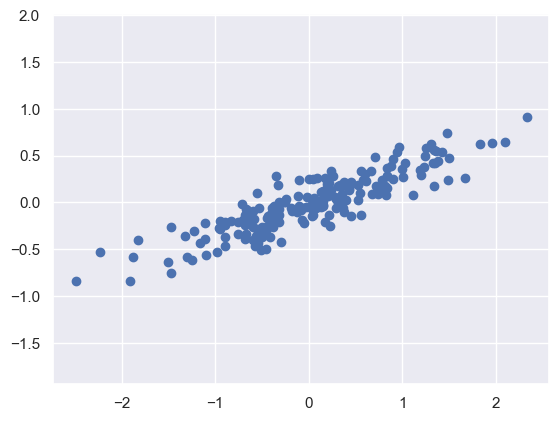

In [33]:
# sets the random state
rng = np.random.RandomState(1)

# makes 200 random points
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T

# plots the graph
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

This looks like a linear regression problem, however, if we did not know this linear trend, we can instead try and learn about the relationship between the _x_ and _y_ values


**In PCA you try and find the _principal axis_ (the axis with the largest variance) of the dataset and use that axis to describe the data**


### Implementing PCA in Scikit-learn


In [34]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

#### What PCA learns?


**Components or Eigenvectors**

These represent the directions of the largest variance


In [35]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


**Variance Explained**

This represents the amount of variance in the dataset explained by the principal component


In [36]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


### Visualizing what PCA is doing

1. Finds the direction of highest variance and draws a vector in that direction (eigenvector)
2. Projects all of the data points onto that dimension (eigenvalues)
3. Finds the next direction orthogonal to the first PC that has the largest variance. <br>

Process 2 and 3 repeats for the number of components selected


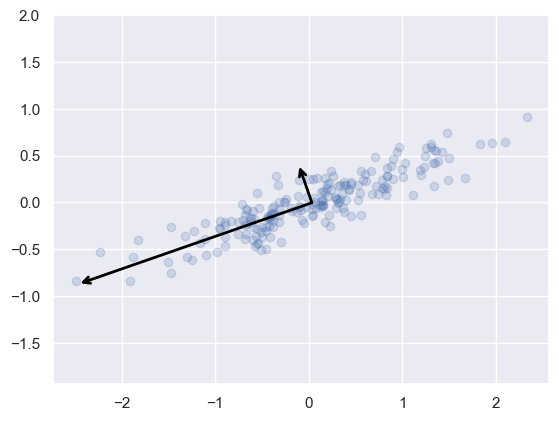

In [37]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color='black')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

**What does this graph show?**

- These vectors represent the principal axes in the data
- The length of the vector indicates how important that axis is in describing the distribution (the variance)


[Text(0.5, 0, 'component 1'),
 Text(0, 0.5, 'component 2'),
 Text(0.5, 1.0, 'principal components'),
 (-5.0, 5.0),
 (-3.0, 3.1)]

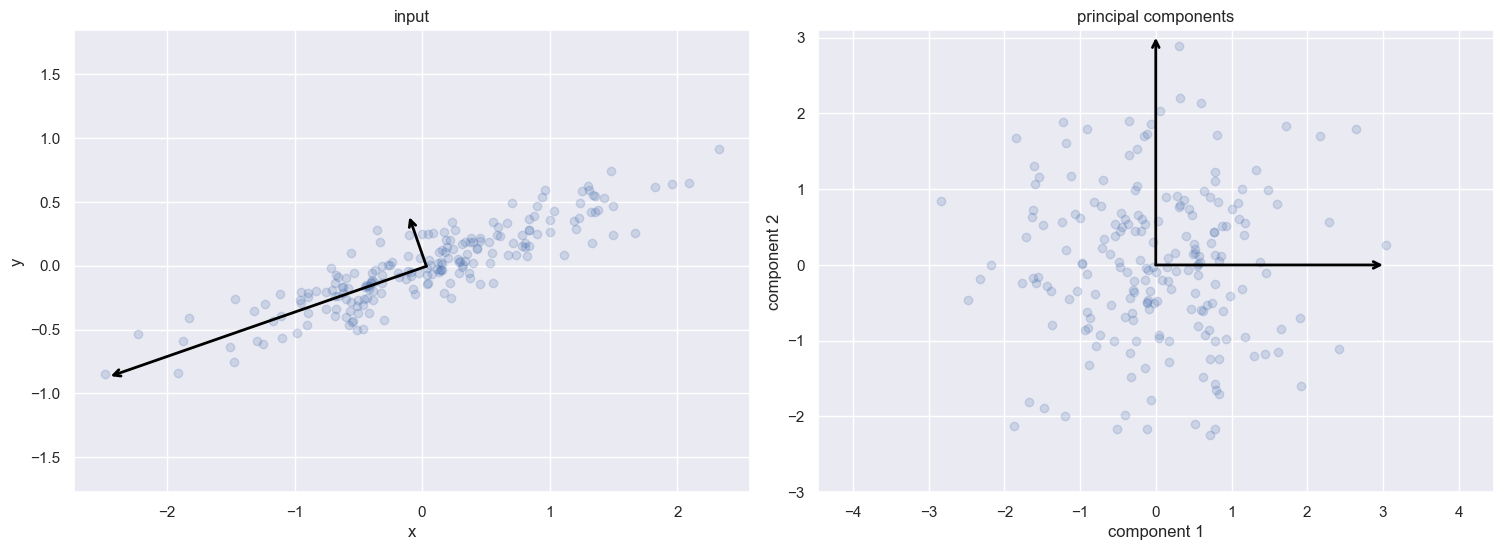

In [38]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
pca = PCA(n_components=2, whiten=True)
pca.fit(X)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# plot data
ax[0].scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax[0])
ax[0].axis('equal');
ax[0].set(xlabel='x', ylabel='y', title='input')

# plot principal components
X_pca = pca.transform(X)
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)
draw_vector([0, 0], [0, 3], ax=ax[1])
draw_vector([0, 0], [3, 0], ax=ax[1])
ax[1].axis('equal')
ax[1].set(xlabel='component 1', ylabel='component 2',
          title='principal components',
          xlim=(-5, 5), ylim=(-3, 3.1))

- At first, this might appear to be something of mathematical interest but it has far-reaching implications.
  - You are saying that you can break down data into a set of orthogonal directions and values and describe the data well.
  - You choose the directions of maximum variance thus the higher components contain less information


### Use Cases for PCA


#### Dimensionality Reduction

You can take data that exists in a high-dimensional space and approximate it in a lower-dimensional space


**Example:** taking 2d data and converting it into 1d


In [39]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


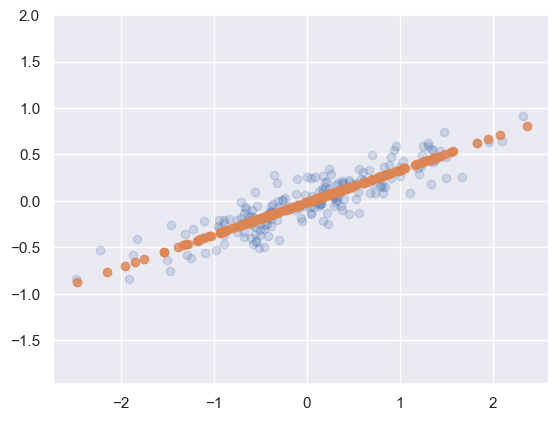

In [40]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

Blue points represent the raw data, orange points represent the projected dimension


- When you conduct PCA some information is lost, however, most of the information is retained.
- The question you have to ask is the representation is "good enough"
- If you have noisy data PCA can help remove uncorrelated variance


In this case, most of the information is retained while the dimensionality of the data was reduced by half


### Real Example of PCA


In [41]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


**Split into a training set and a test set using a stratified k-fold**


In [42]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

**Training a classifier without PCA**


In [43]:
# Train a SVM classification model

clf = SVC(kernel='linear')
clf = clf.fit(X_train, y_train)

**Evaluation of Model Quality**


Predicting people's names on the test set
done in 0.176s
                   precision    recall  f1-score   support

     Ariel Sharon       0.69      0.85      0.76        13
     Colin Powell       0.85      0.87      0.86        60
  Donald Rumsfeld       0.57      0.63      0.60        27
    George W Bush       0.89      0.91      0.90       146
Gerhard Schroeder       0.69      0.72      0.71        25
      Hugo Chavez       0.70      0.47      0.56        15
       Tony Blair       0.80      0.67      0.73        36

         accuracy                           0.81       322
        macro avg       0.74      0.73      0.73       322
     weighted avg       0.81      0.81      0.81       322



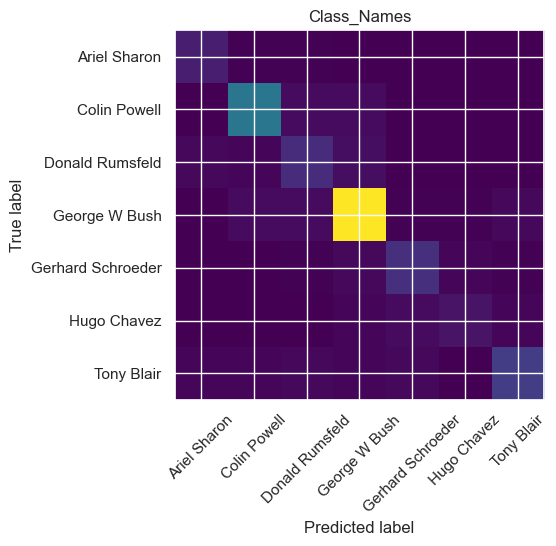

In [44]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))


cm = confusion_matrix(y_test, y_pred, labels=range(n_classes))

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.viridis)
plt.title('Class_Names')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
plt.show()


**Compute PCA**


In [45]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 10.765s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.024s


**Train and SVM on the PCA data**


In [46]:
# Train a SVM classification model
# This will take about 7 minutes

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 23.280s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


**Evaluation of Model Quality**


Predicting people's names on the test set
done in 0.184s
                   precision    recall  f1-score   support

     Ariel Sharon       0.90      0.69      0.78        13
     Colin Powell       0.89      0.78      0.83        60
  Donald Rumsfeld       0.67      0.52      0.58        27
    George W Bush       0.77      0.95      0.85       146
Gerhard Schroeder       0.79      0.60      0.68        25
      Hugo Chavez       0.67      0.27      0.38        15
       Tony Blair       0.70      0.64      0.67        36

         accuracy                           0.78       322
        macro avg       0.77      0.64      0.68       322
     weighted avg       0.78      0.78      0.77       322



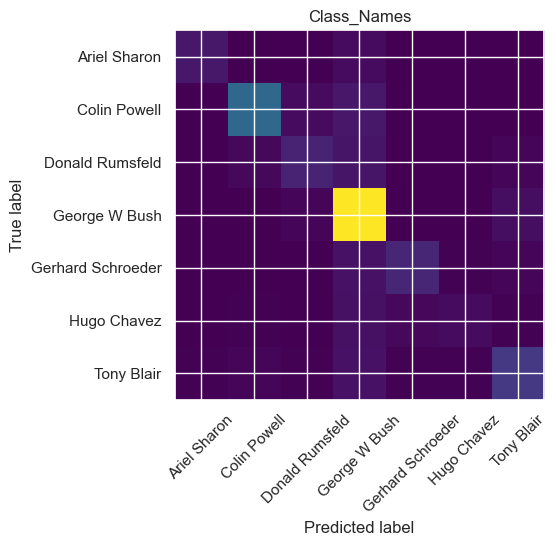

In [47]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))


cm = confusion_matrix(y_test, y_pred, labels=range(n_classes))

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.viridis)
plt.title('Class_Names')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
plt.show()


**PCA of Faces**


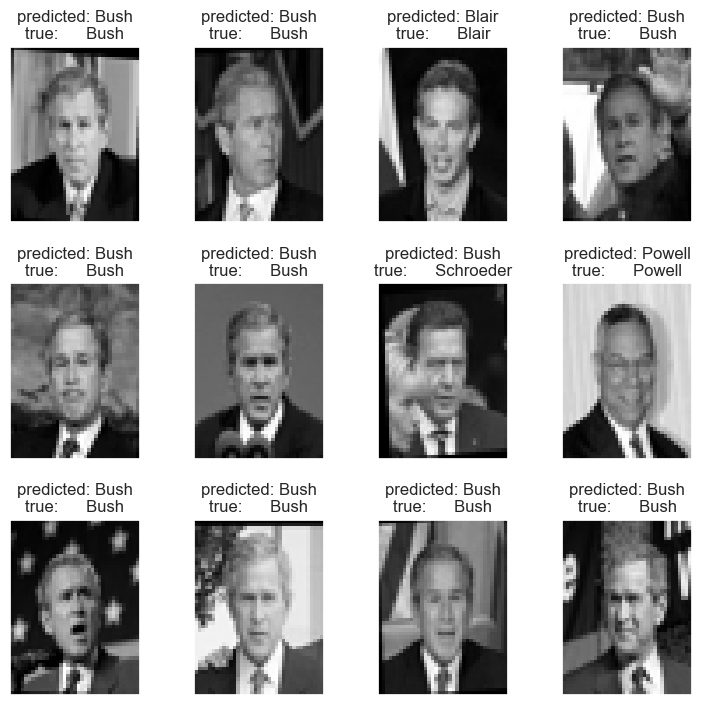

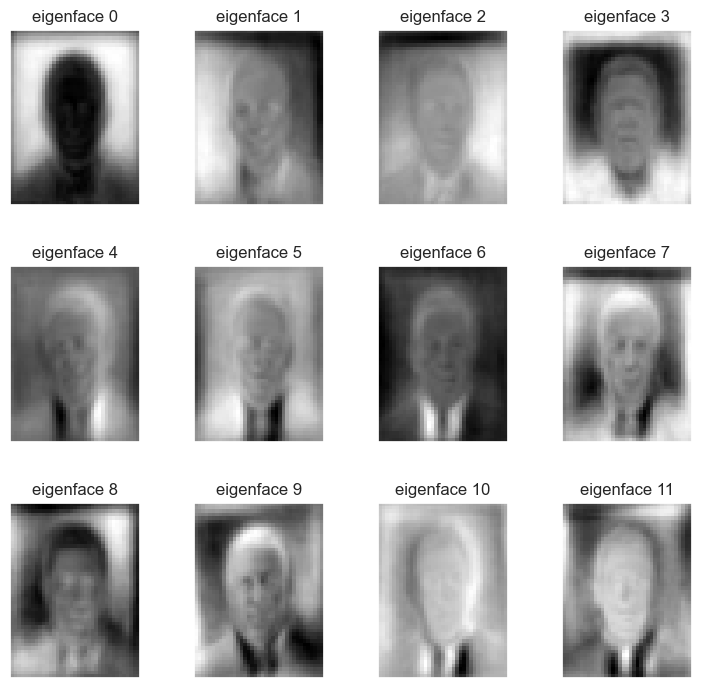

In [48]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

PCA can help reduce the curse of dimensionality. It is one way to help prevent overfitting.


## Independent Component Analysis


- Tries to split signals into their fundamental components


You can think of this as **the cocktail party problem**. Imagine you are in a room with a bunch of people talking. How can you hear one person excluding the noise


**Visual comparison between PCA and ICA**


c:\Users\jca92\.conda\envs\jupyterbook\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


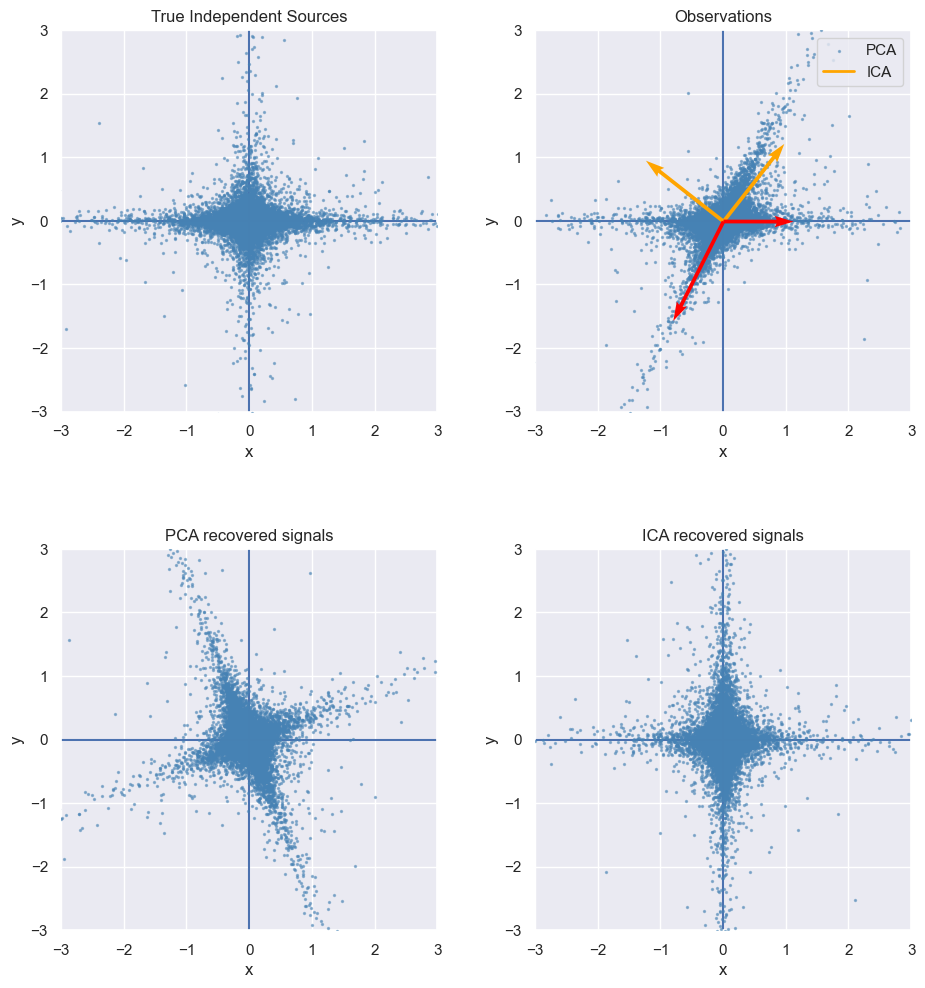

In [49]:

# Authors: Alexandre Gramfort, Gael Varoquaux
# License: BSD 3 clause
# #############################################################################
# Generate sample data
rng = np.random.RandomState(42)
S = rng.standard_t(1.5, size=(20000, 2))
S[:, 0] *= 2.

# Mix data
A = np.array([[1, 1], [0, 2]])  # Mixing matrix

X = np.dot(S, A.T)  # Generate observations

pca = PCA()
S_pca_ = pca.fit(X).transform(X)

ica = FastICA(random_state=rng)
S_ica_ = ica.fit(X).transform(X)  # Estimate the sources

S_ica_ /= S_ica_.std(axis=0)


# #############################################################################
# Plot results

def plot_samples(S, axis_list=None):
    plt.scatter(S[:, 0], S[:, 1], s=2, marker='o', zorder=10,
                color='steelblue', alpha=0.5)
    if axis_list is not None:
        colors = ['orange', 'red']
        for color, axis in zip(colors, axis_list):
            axis /= axis.std()
            x_axis, y_axis = axis
            # Trick to get legend to work
            plt.plot(0.1 * x_axis, 0.1 * y_axis, linewidth=2, color=color)
            plt.quiver(0, 0, x_axis[0], y_axis[0], zorder=11, width=0.01, scale=6,
                       color=color)
            plt.quiver(0, 0, x_axis[1], y_axis[1], zorder=11, width=0.01, scale=6,
                       color=color)

    plt.hlines(0, -3, 3)
    plt.vlines(0, -3, 3)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.xlabel('x')
    plt.ylabel('y')

plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plot_samples(S / S.std())
plt.title('True Independent Sources')

axis_list = [pca.components_.T, ica.mixing_]
plt.subplot(2, 2, 2)
plot_samples(X / np.std(X), axis_list=axis_list)
legend = plt.legend(['PCA', 'ICA'], loc='upper right')
legend.set_zorder(100)

plt.title('Observations')

plt.subplot(2, 2, 3)
plot_samples(S_pca_ / np.std(S_pca_, axis=0))
plt.title('PCA recovered signals')

plt.subplot(2, 2, 4)
plot_samples(S_ica_ / np.std(S_ica_))
plt.title('ICA recovered signals')

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.36)

ICA looks for directions in the data space that are highly non-Gaussian


### ICA for Spectral Unmixing

**A more practical example solving the cocktail party problem**

Independent component analysis allows you to do blind source separation. If you have multiple signals and multiple detectors ICA can identify the independent signals.


We will start by creating some independent signals that will be mixed by matrix A. The independent sources signals are **(1)** a sine wave, **(2)** a saw tooth signal and **(3)** a random noise vector. After calculating their dot product with _A_ we get three linear combinations of these source signals.


In [50]:

np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

In [51]:
# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

c:\Users\jca92\.conda\envs\jupyterbook\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


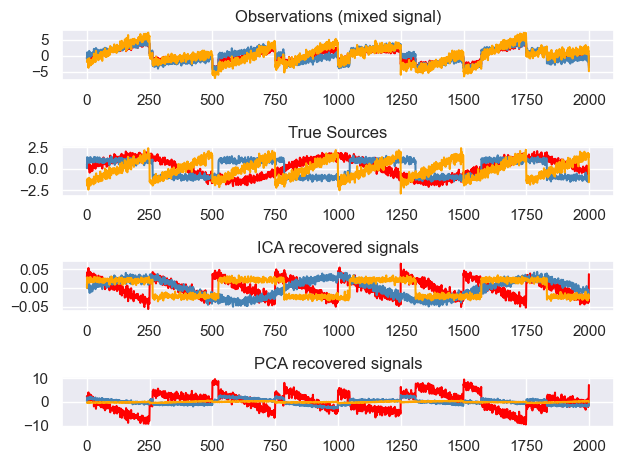

In [52]:
plt.figure()

models = [X, S, S_, H]
names = [
    "Observations (mixed signal)",
    "True Sources",
    "ICA recovered signals",
    "PCA recovered signals",
]
colors = ["red", "steelblue", "orange"]

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

## Non-Negative Matrix Factorization


- matrix factorization method where we constrain the matrices to be nonnegative


**What is matrix factorization?**


If we want to factor $X$ into two matrices $W$ and $H$ there is no guarantee that we can recover the original matrix
$$X \approx WH$$


suppose that $X$ is composed of m rows $x_1, x_2, ... x_m$ , $W$ is composed of $k$ rows $w_1, w_2, ... w_k$ , $H$
is composed of $m$ rows $h_1, h_2, ... h_m$ .

- Each row in $X$ can be considered a data point.
- For instance, in the case of decomposing images, each row in $X$ is a single image, and each column represents some feature.


![figure](figs/mf_concept.png)


- $x$ is the sum of weights multiplied by components


- We add conditions to the weights. In the case of NMF, it is that the weights are non-negative.


**When do we use NMF**


- Good when underlying factors can be interpreted as non-negative


**Comparison to PCA**


- PCA is another common matrix factorization technique
- Factors can have positive and negative values ... Why do you think this might be bad?


![figure](figs/pca_faces.png)


- Components do not make that much sense
- Hard to interpret what positive and negative components mean


**NMF all the values are positive**

- The components have interpretable meanings


![figure](figs/nmf_faces.png)


- Different components look like different features of a face.


### Example: NMF on MNIST


**Set Parameters**


In [53]:
train_samples = 1000
nmf_components = 49
np.random.seed(0)

#### Import Data


In [54]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

inputs_train = X_train[0:train_samples].astype('float32') / 255.
inputs_train = inputs_train.reshape((len(inputs_train), np.prod(inputs_train.shape[1:])))

'''
inputs_test = X_test[0:train_samples].astype('float32') / 255.
inputs_test = inputs_test.reshape((len(inputs_test), np.prod(inputs_test.shape[1:])))
'''

"\ninputs_test = X_test[0:train_samples].astype('float32') / 255.\ninputs_test = inputs_test.reshape((len(inputs_test), np.prod(inputs_test.shape[1:])))\n"

#### Plots Raw Images


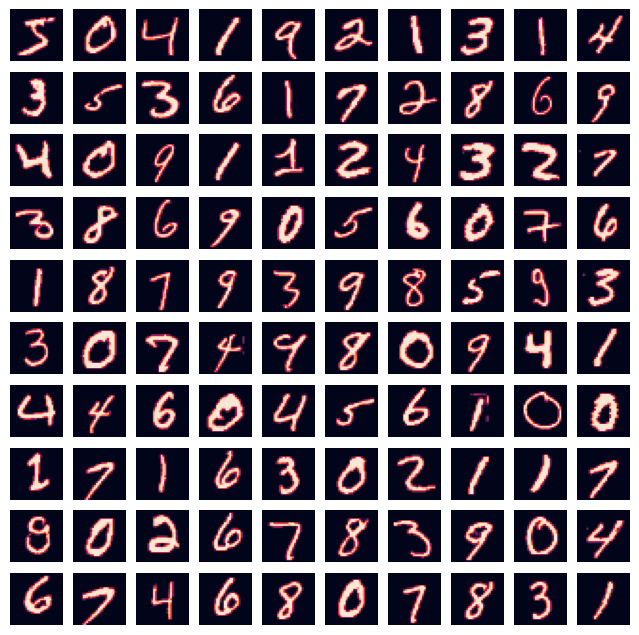

In [55]:
fig=plt.figure(figsize=(8, 8))
rows = min(int(np.sqrt(train_samples)),10)
columns = min(int(train_samples / rows),10)
for i in range(0, columns*rows):
    img = inputs_train[i].reshape((28, 28))
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.imshow(img)
plt.show()

#### Conducts NMF


c:\Users\jca92\.conda\envs\jupyterbook\lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


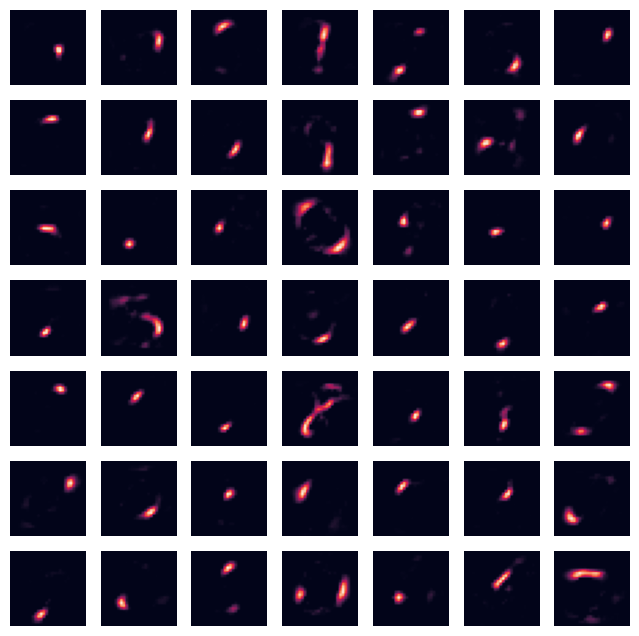

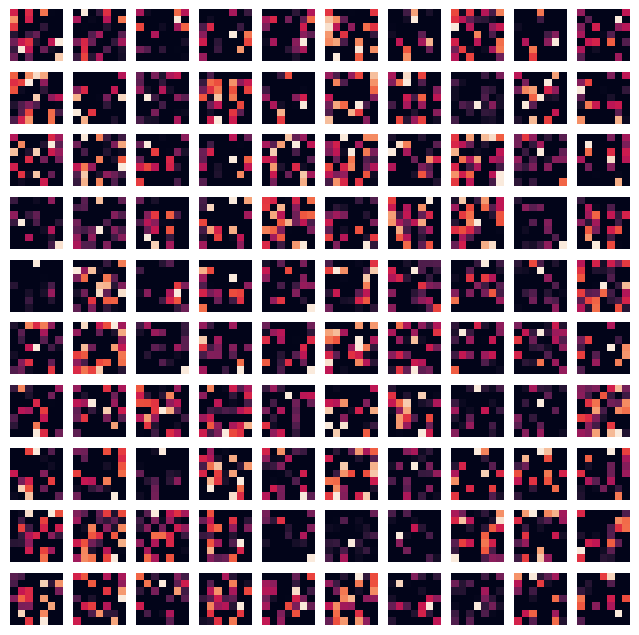

In [56]:

# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
nmf = NMF(n_components=nmf_components, random_state=0, solver='mu', init='random', max_iter=200, tol=1e-4)

W = nmf.fit_transform(inputs_train)
H = nmf.components_

# H = n_components x pixels (list of components)

fig=plt.figure(figsize=(8, 8))
rows = min(int(np.sqrt(nmf_components)),10)
columns = min(int(nmf_components / rows),10)
for i in range(0, columns*rows):
    img = H[i].reshape((28, 28))
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.imshow(img)
plt.show()

# W = samples x n_components (component mapping for each sample)

fig=plt.figure(figsize=(8, 8))
rows = min(int(np.sqrt(train_samples)),10)
columns = min(int(train_samples / rows),10)
for i in range(0, columns*rows):
    img = W[i].reshape((int(np.sqrt(nmf_components)), int(np.sqrt(nmf_components))))
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.imshow(img)
plt.show()

#### Reconstruction


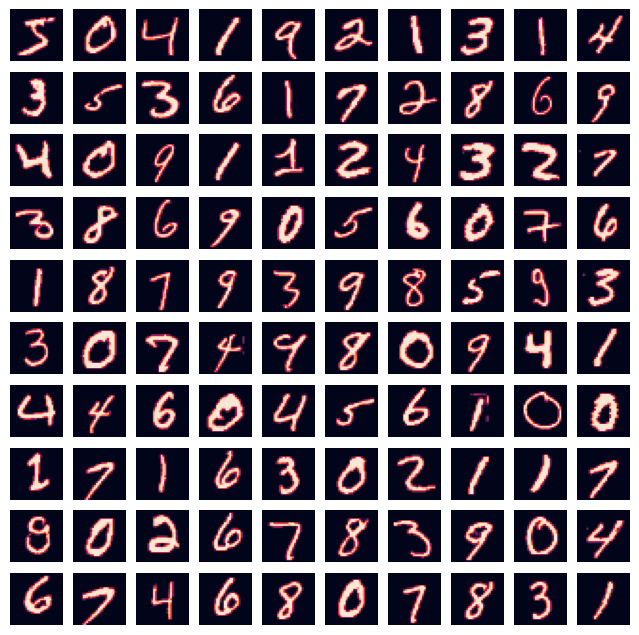

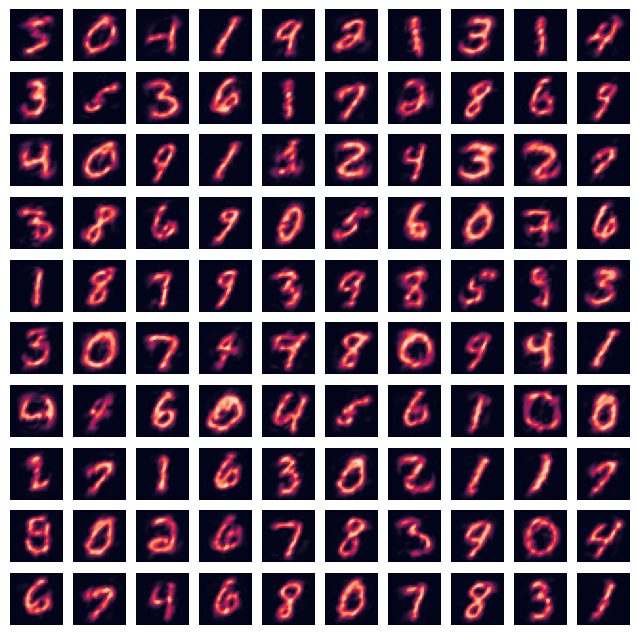

In [57]:
output = nmf.inverse_transform(W)

fig=plt.figure(figsize=(8, 8))
rows = min(int(np.sqrt(train_samples)),10)
columns = min(int(train_samples / rows),10)
for i in range(0, columns*rows):
    img = inputs_train[i].reshape((28, 28))
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.imshow(img)
plt.show()

fig=plt.figure(figsize=(8, 8))
rows = min(int(np.sqrt(train_samples)),10)
columns = min(int(train_samples / rows),10)
for i in range(0, columns*rows):
    img = output[i].reshape((28, 28))
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.imshow(img)
plt.show()